# Imports and installations

In [1]:
!pip install transformers
!pip install biopython
!pip install Levenshtein
!pip install pyjarowinkler
!pip install phonetic-algorithmIPA
!pip install tqdm

In [2]:
import os

import math

from tqdm import tqdm

import hashlib
import random

import numpy as np
import pandas as pd

import re

from transformers import AutoTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from itertools import cycle

from Bio import Phylo
from Bio.Phylo.TreeConstruction import _DistanceMatrix
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor

import matplotlib
import matplotlib.pyplot as plt

import Levenshtein
from pyjarowinkler.distance import get_jaro_distance as jw
from phonetic_algorithmIPA import ipa_distances

In [3]:
pd.options.mode.chained_assignment = None

# Data loading and preprocessing

We start with loading dataset of the following format:
        
| Concept     | Lect1 | ... | LectN |
| ----------- | ----------- |----------- | ----------- |
| Concept 1 title in English | Concept 1 title in Lect 1 | ... | Concept 1 title in lect N |
| ... | ... | ... | ... |
| Concept M title in English | Concept M title in Lect 1 | ... | Concept M title in lect N |

In [4]:
# We store current dataset name in variable DATA
DATA = 'South Slavic lects'
start_df = pd.read_csv("/home/ilia/Дакументы/Старостинские чтения'24/Data/Swadesh lists - South Slavic for outgroup comparison.csv", sep=',')
# drop concepts, for which we cannot compare lects
start_df = start_df.dropna()

In [5]:
start_df.head()

,Concept,Govor Lužnice,Govor Kuča,Govor Hvara,Govor severne Metohije
0,blood,krv,krv,"kor, korv",krv
1,bone,"kos, koska, koʧina, koʃʧina",kos,kost,kos
2,breast (woman’s),"grudi, pazuka, siska","grudi, ɲedra, prsi, sisa","nidra, parsi, sisa","grudi, ʥuks, prsi, sisa"
3,come,"dojde, doodi","doj, dodit","arivat, arivovat, doʨ","doʨ, doj, dojti, dolazit"
4,die,"umira, umre","umirat, umrijet","partivat, portit, umirot, umrit",umret


In [6]:
start_df.shape

(38, 5)

Then we acquire lect names.

In [7]:
lect_rows = start_df.drop('Concept', axis=1)

In [8]:
lects = list(lect_rows.columns)

In [9]:
print(lects)

['Govor Lužnice', 'Govor Kuča', 'Govor Hvara', 'Govor severne Metohije']


Then we transform the data in the format of dictionary, with the lect *i* name as a key, and list of pairs *concept j name in english - concept in lect i* as value for each *j* in concept list.

In [10]:
wordlists = {}
for i in lects:
  wordlists[i] = list(zip(list(start_df['Concept']), list(start_df[i])))

In [11]:
print(wordlists)

{'Govor Lužnice': [('blood', 'krv'), ('bone', 'kos, koska, koʧina, koʃʧina'), ('breast (woman’s)', 'grudi, pazuka, siska'), ('come', 'dojde, doodi'), ('die', 'umira, umre'), ('dog', 'kuʧe, pseto, pʦeto'), ('drink (verb)', 'pije, popije'), ('ear', 'uo'), ('eye', 'oko'), ('fire', 'ogaɲ'), ('fish (noun)', 'riba'), ('full', 'pun'), ('hand', 'ruka'), ('hear', 'ʧuje'), ('horn (animal part)', 'rog'), ('I', 'ja'), ('knee', 'koleno'), ('liver', 'ʤigeriʦa, ʤiʥeriʦa, ʥiʤeriʦa, drob, ʦrni drob'), ('mountain', 'gora, planina'), ('name (noun)', 'ime'), ('new', 'nov'), ('night (dark time)', 'noʧ'), ('nose', 'nos'), ('one', 'jedən'), ('path', 'put'), ('person', 'ʧovek'), ('see', 'vidi'), ('skin', 'koʒa'), ('star', 'zvezda'), ('stone', 'kamik'), ('sun', 'slnʦe'), ('tongue', 'jezik'), ('tooth', 'zub'), ('tree', 'drvo'), ('two', 'dva'), ('water', 'voda'), ('we', 'mi'), ('you', 'ti')], 'Govor Kuča': [('blood', 'krv'), ('bone', 'kos'), ('breast (woman’s)', 'grudi, ɲedra, prsi, sisa'), ('come', 'doj, dodit'

Then we glue all the possible instances of each concept, if there are more than one, with "_" symbol, in order to confuse tokeniser, giving it no additional clue that there is more than one word.

In [12]:
for k, v in wordlists.items():
  new_v = []
  for concept in v:
    new_value = concept[1].split(', ')
    new_v.append((concept[0], '_'.join(new_value)))
  wordlists[k] = new_v

In [13]:
print(wordlists)

{'Govor Lužnice': [('blood', 'krv'), ('bone', 'kos_koska_koʧina_koʃʧina'), ('breast (woman’s)', 'grudi_pazuka_siska'), ('come', 'dojde_doodi'), ('die', 'umira_umre'), ('dog', 'kuʧe_pseto_pʦeto'), ('drink (verb)', 'pije_popije'), ('ear', 'uo'), ('eye', 'oko'), ('fire', 'ogaɲ'), ('fish (noun)', 'riba'), ('full', 'pun'), ('hand', 'ruka'), ('hear', 'ʧuje'), ('horn (animal part)', 'rog'), ('I', 'ja'), ('knee', 'koleno'), ('liver', 'ʤigeriʦa_ʤiʥeriʦa_ʥiʤeriʦa_drob_ʦrni drob'), ('mountain', 'gora_planina'), ('name (noun)', 'ime'), ('new', 'nov'), ('night (dark time)', 'noʧ'), ('nose', 'nos'), ('one', 'jedən'), ('path', 'put'), ('person', 'ʧovek'), ('see', 'vidi'), ('skin', 'koʒa'), ('star', 'zvezda'), ('stone', 'kamik'), ('sun', 'slnʦe'), ('tongue', 'jezik'), ('tooth', 'zub'), ('tree', 'drvo'), ('two', 'dva'), ('water', 'voda'), ('we', 'mi'), ('you', 'ti')], 'Govor Kuča': [('blood', 'krv'), ('bone', 'kos'), ('breast (woman’s)', 'grudi_ɲedra_prsi_sisa'), ('come', 'doj_dodit'), ('die', 'umirat_

After we have acquired the data, our purpose is to change it in such a way that it becomes almost unexplainable for a human, but still comprehensible for a computer. We start with using SHA-256 hash function for each word in our wordlist.

In [14]:
hashed_wordlists = {}
for i in wordlists:
  hashed_wordlists[i] = [(j[0], str(hashlib.sha256(j[1].encode()).hexdigest())) for j in wordlists[i]]

In [15]:
print(hashed_wordlists)

{'Govor Lužnice': [('blood', '638ae3976ba2aa40cd68d173a3fcb31c757241bff712b05e421b6e963612f5bc'), ('bone', '5c81aa937b0b27d6d1fe386fa7aa1f467ba93f85e7bd138ed920ad570518e150'), ('breast (woman’s)', 'c44479e042309ab6707f3065f85b7c6508aeb37ddf7635107acad56c7a3f0aa0'), ('come', '83516aeea579e750e296f8214d82cb4120c582789dde76e2c74287e9d0319164'), ('die', 'c3ca5fbd7fc3d5f115536baca780646c3a5c17f0e5be6dd90fb809e7c8b73cd3'), ('dog', '97a9b4c316c105a4c0ad1d193c6b98d59f9fc000aa835933ed62e875dc76b0d6'), ('drink (verb)', '43609dc4f773842aaf58aad1f91685c139b066b01f581348d046bfaa61ebd502'), ('ear', '6ad39835c3d6d768a05ed3fac56a928168c1295ca0a47563164e05cc78a93f9f'), ('eye', '0b4c62acca23587fe72daa1b3e1ffd0fd404195c18648a2738a65576b46b2ddc'), ('fire', 'f1f0a1231511c34140b68b520acdba661680a5f7e68af0783e11df9e8641c823'), ('fish (noun)', '60d35c3bec11b8839b4baee8abedd7bf46bb80fdd7f07d57a94158555389a070'), ('full', '0a5f508c137400ec7043092e3a076e015994ecef09c9c06828c4ba602128b6e0'), ('hand', '4f20a86d07c

In [16]:
print(hashed_wordlists[lects[1]][2] == hashed_wordlists[lects[2]][2])

False


In [17]:
print(hashed_wordlists[lects[1]][0] == hashed_wordlists[lects[2]][0])

False


We then tokenize hash strings. This disrupts strict one-to-one connection of a word to a hash string. We use Byte-Pair Encoder (BPE) Tokenizer (of GPT-2, as it is available from scratch from HuggingFace), as there are hardly any words, similar to parts of hash string, in human languages. We are, however, much more likely to meet subwords.

In [18]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [19]:
tokenized_wordlists = {}
for i in hashed_wordlists:
  tokenized_wordlists[i] = [(j[0], ' '.join(tokenizer.tokenize(j[1]))) for j in hashed_wordlists[i]]

In [20]:
print(tokenized_wordlists)

{'Govor Lužnice': [('blood', '6 38 ae 39 76 ba 2 aa 40 cd 68 d 173 a 3 fc b 31 c 757 241 b ff 712 b 05 e 421 b 6 e 96 36 12 f 5 bc'), ('bone', '5 c 81 aa 9 37 b 0 b 27 d 6 d 1 fe 386 fa 7 aa 1 f 467 ba 93 f 85 e 7 bd 138 ed 920 ad 5 705 18 e 150'), ('breast (woman’s)', 'c 44 479 e 04 230 9 ab 6 707 f 30 65 f 85 b 7 c 650 8 a eb 37 dd f 76 35 107 ac ad 56 c 7 a 3 f 0 aa 0'), ('come', '8 35 16 a ee a 579 e 750 e 296 f 82 14 d 82 cb 4 120 c 58 27 89 dd e 76 e 2 c 74 287 e 9 d 03 19 164'), ('die', 'c 3 ca 5 f bd 7 fc 3 d 5 f 11 55 36 b aca 780 646 c 3 a 5 c 17 f 0 e 5 be 6 dd 90 fb 809 e 7 c 8 b 73 cd 3'), ('dog', '97 a 9 b 4 c 316 c 105 a 4 c 0 ad 1 d 193 c 6 b 98 d 59 f 9 fc 000 aa 8 359 33 ed 62 e 875 dc 76 b 0 d 6'), ('drink (verb)', '43 609 dc 4 f 77 38 42 a af 58 a ad 1 f 916 85 c 139 b 0 66 b 01 f 58 13 48 d 046 bf aa 61 eb d 502'), ('ear', '6 ad 398 35 c 3 d 6 d 768 a 05 ed 3 fac 56 a 9 28 168 c 12 95 ca 0 a 475 63 164 e 05 cc 78 a 93 f 9 f'), ('eye', '0 b 4 c 62 acca 23 587 fe 72 

In [21]:
df = pd.DataFrame(columns=['concept', 'word', 'hashed_word', 'lect'])
for i in tokenized_wordlists:
  for j in range(len(tokenized_wordlists[i])):
    df.loc[len(df)] = [wordlists[i][j][0], wordlists[i][j][1], tokenized_wordlists[i][j][1], i]

We finally produce dataset of four columns and LECT_NUMBER * CONCEPT_NUMBER rows.

In [22]:
df.head()

,concept,word,hashed_word,lect
0,blood,krv,6 38 ae 39 76 ba 2 aa 40 cd 68 d 173 a 3 fc b ...,Govor Lužnice
1,bone,kos_koska_koʧina_koʃʧina,5 c 81 aa 9 37 b 0 b 27 d 6 d 1 fe 386 fa 7 aa...,Govor Lužnice
2,breast (woman’s),grudi_pazuka_siska,c 44 479 e 04 230 9 ab 6 707 f 30 65 f 85 b 7 ...,Govor Lužnice
3,come,dojde_doodi,8 35 16 a ee a 579 e 750 e 296 f 82 14 d 82 cb...,Govor Lužnice
4,die,umira_umre,c 3 ca 5 f bd 7 fc 3 d 5 f 11 55 36 b aca 780 ...,Govor Lužnice


# Black-box

## Scoring the original result

We start the experiment with performing lect classification task on the tokenised hashes we acquired.

In [23]:
# vectorise data, in order for the model to be able to deal with it
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
X = vectorizer.fit_transform(list(df['hashed_word'])).toarray()

In [24]:
print(X[0])

[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1]


In [25]:
assert len(X) == df.shape[0]

In [26]:
y = list(df['lect'])

In [27]:
y

['Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Lužnice',
 'Govor Kuča',
 'Govor Kuča',
 'Govor Kuča',
 'Govor Kuča',
 'Govor Kuča',
 'Govor Kuča',
 'Govor Kuča',
 'Govor Kuča',
 'Govor Kuča',
 'Govor Kuča',
 'Govor Kuča',
 'Govor Kuča',
 'Govor Kuča',
 'Govor Kuča',
 'Govor Kuča',
 'Govor Kuča',
 'Govor Kuča',
 'Govor Kuča',
 'Govor Kuča',
 'Govor Kuča',
 'Govor Kuča',
 

In [28]:
assert len(X) == len(y)

At this stage, we attempted to make our data even harder for a model, adding salt and pepper noise. The transformation would make the data is barely understandable for a human, increasing black-box-ness of a proposed method, and does not change a data to either completely incomprehensible (as random noise would do), or comprehensible, yet fully transformed (as Gaussian noise would do).

However, noise would bring its own *features* to the model, and becoming too dependent on its fluctuations will make experiments impossible even for the black-box condition.

We are using Random Forest classifier, as it:

* trains for a small amount of time
* is one of the simplest and the most effective classical ML classifiers
* is a hard task for explainability systems

For evaluation, we use the micro-F1 score. We use it specifically, as it is a widespread method of evaluating lect classification and identification. We score mean micro-F1 score between 5-folds via cross-validation. We use it specifically, as it is a widespread method of evaluating lect classification and identification.

We use cross-validation, as our dataset is very small, and strictly splitting it into train/test may significantly affect the result.

In [29]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
scores = cross_val_score(classifier, X, y, cv=5, scoring='f1_micro')
print(scores)

[0.29032258 0.19354839 0.3        0.16666667 0.26666667]


Here, we remember the mean micro-F1 score for the further comparison

In [30]:
ideal_score_random_forest = (sum(scores)/len(scores))
print(ideal_score_random_forest)

0.2434408602150538


## Experiments

We acquire all the possible unique lect pairs, and then split the dataset by lects.

In [31]:
unique_pairs = []
for i in set(y):
  for j in set(y):
    if (i != j) and (i, j) not in unique_pairs and (j, i) not in unique_pairs:
      unique_pairs.append((i, j))
print(unique_pairs)

[('Govor Lužnice', 'Govor severne Metohije'), ('Govor Lužnice', 'Govor Kuča'), ('Govor Lužnice', 'Govor Hvara'), ('Govor severne Metohije', 'Govor Kuča'), ('Govor severne Metohije', 'Govor Hvara'), ('Govor Kuča', 'Govor Hvara')]


In [32]:
df_pairs = [(i, df[df['lect'] == i]) for i in set(y)]

In [33]:
df_pairs

[('Govor Lužnice',
                 concept                                       word  \
  0                blood                                        krv   
  1                 bone                   kos_koska_koʧina_koʃʧina   
  2     breast (woman’s)                         grudi_pazuka_siska   
  3                 come                                dojde_doodi   
  4                  die                                 umira_umre   
  5                  dog                           kuʧe_pseto_pʦeto   
  6         drink (verb)                                pije_popije   
  7                  ear                                         uo   
  8                  eye                                        oko   
  9                 fire                                       ogaɲ   
  10         fish (noun)                                       riba   
  11                full                                        pun   
  12                hand                                  

In [34]:
# here we get all the lects but the pair in consideration
def get_non_relevant_pairs(pair, pairs_df):
  return pd.concat([k[1] for k in df_pairs if pair[0] != k[0] and pair[1] != k[0]])

We gather data for final clusterisation in the following way:
* For each pair of lects
 * Swap THRESHOLD (not too big, we try 3, 5, 8, 11, 14) random concepts between lects; or, if we experience LANGUAGE_CONTACT situation, transfer concepts from one lect to another.
 * Re-train and re-evaluate Random Forest classifier
 * Get square error
 * Get mean square error for this pair of lects
* Form array of such distances to triangular matrix

We perform this NUM_RUNS times, to get a more weighted picture

In [35]:
THRESHOLD = 3

In [36]:
# we additionally score minimal required number of runs
# defined by chance of switching all the concepts
# across the span of experiments
iteration_num = 1
other_items = start_df.shape[0] - THRESHOLD
overall_items = start_df.shape[0]
negative_prob = other_items/overall_items
while True:
    given_item_prob = (1 - math.pow(negative_prob, iteration_num))
    if given_item_prob == 1:
        break
    iteration_num = iteration_num + 1
print(f'Recommended number of runs for {THRESHOLD} swaps among {start_df.shape[0]} concepts is more than {iteration_num}')
    

Recommended number of runs for 3 swaps among 38 concepts is more than 456


In [37]:
LANGUAGE_CONTACT = 0
NUM_RUNS = 1000

In [38]:
pairwise_distances = []
for r in tqdm(range(NUM_RUNS)):
  pairwise_distances.append([])
  for i in unique_pairs:
    neutral_lects = get_non_relevant_pairs(i, df_pairs)
    # get data for pair under consideration
    lect_1 = df[df['lect'] == i[0]]
    lect_2 = df[df['lect'] == i[1]]
    # get all the concept
    concepts = list(lect_1['concept'].unique())
    # copy for two dfs not to become a copy of one another
    current_lect_1 = lect_1.copy().reset_index()
    current_lect_2 = lect_2.copy().reset_index()
    for j in range(THRESHOLD):
      current_concept = np.random.randint(len(concepts))
      # transfer concept from lect 2 to lect 1, and vice versa,
      # if we do not model language contact
      temp = current_lect_1.iloc[current_concept]
      current_lect_1.iloc[current_concept] = current_lect_2.iloc[current_concept]
      if not LANGUAGE_CONTACT:
        current_lect_2.iloc[current_concept] = temp
    # restore uniformity of lect column, making swap invisible to machine
    current_lect_1['lect'] = i[0]
    current_lect_2['lect'] = i[1]
    # restore the full dataset
    final_df = pd.concat([current_lect_1, current_lect_2, neutral_lects])
    # reperform classification
    X = vectorizer.fit_transform(list(final_df['hashed_word'])).toarray()
    y = list(df['lect'])
    classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
    scores = cross_val_score(classifier, X, y, cv=5, scoring='f1_micro')
    score_random_forest = max(scores)/len(scores)
    # compare new micro-F1 to original score; multiply by itself, in order to evade negative values
    current_score = (ideal_score_random_forest - score_random_forest) ** 2
    # get mean for all the concepts in pair
    pairwise_distances[r].append((i, current_score))
print(pairwise_distances)

100%|█████████████████████████████████████| 1000/1000 [6:32:55<00:00, 23.58s/it]

[[(('Govor Lužnice', 'Govor severne Metohije'), 0.03679796508266853), (('Govor Lužnice', 'Govor Kuča'), 0.03614087177708406), (('Govor Lužnice', 'Govor Hvara'), 0.0336505491964389), (('Govor severne Metohije', 'Govor Kuča'), 0.0336505491964389), (('Govor severne Metohije', 'Govor Hvara'), 0.03436438894669905), (('Govor Kuča', 'Govor Hvara'), 0.03614087177708406)], [(('Govor Lužnice', 'Govor severne Metohije'), 0.03436438894669905), (('Govor Lužnice', 'Govor Kuča'), 0.0336505491964389), (('Govor Lužnice', 'Govor Hvara'), 0.03872008324661812), (('Govor severne Metohije', 'Govor Kuča'), 0.02974697652907851), (('Govor severne Metohije', 'Govor Hvara'), 0.03436438894669905), (('Govor Kuča', 'Govor Hvara'), 0.03614087177708406)], [(('Govor Lužnice', 'Govor severne Metohije'), 0.03436438894669905), (('Govor Lužnice', 'Govor Kuča'), 0.03614087177708406), (('Govor Lužnice', 'Govor Hvara'), 0.0336505491964389), (('Govor severne Metohije', 'Govor Kuča'), 0.03679796508266853), (('Govor severne Met

In [39]:
final_matrices = []
for r in range(NUM_RUNS):
  final_matrix = []
  lects = list(set(y))
  row = 0
  for i in range(len(lects)):
    final_matrix.append([])
    for j in range(len(lects)):
      if j < i:
        dist = [d[1] for d in pairwise_distances[r] if set([lects[i], lects[j]]) == set([d[0][0], d[0][1]])][0] 
        final_matrix[i].append(dist)    
    final_matrix[i].append(0)
  final_matrices.append(final_matrix)
print(final_matrices)

[[[0], [0.03679796508266853, 0], [0.03614087177708406, 0.0336505491964389, 0], [0.0336505491964389, 0.03436438894669905, 0.03614087177708406, 0]], [[0], [0.03436438894669905, 0], [0.0336505491964389, 0.02974697652907851, 0], [0.03872008324661812, 0.03436438894669905, 0.03614087177708406, 0]], [[0], [0.03436438894669905, 0], [0.03614087177708406, 0.03679796508266853, 0], [0.0336505491964389, 0.031249115504682637, 0.03679796508266853, 0]], [[0], [0.032014059428835714, 0], [0.03614087177708406, 0.03872008324661812, 0], [0.0336505491964389, 0.03679796508266853, 0.03872008324661812, 0]], [[0], [0.03436438894669905, 0], [0.0336505491964389, 0.03872008324661812, 0], [0.03614087177708406, 0.032014059428835714, 0.03436438894669905, 0]], [[0], [0.03679796508266853, 0], [0.03614087177708406, 0.03614087177708406, 0], [0.0336505491964389, 0.03614087177708406, 0.03872008324661812, 0]], [[0], [0.03679796508266853, 0], [0.0336505491964389, 0.032014059428835714, 0], [0.03679796508266853, 0.036140871777

In [40]:
# create a folder for the trees for future comparison
if not os.path.exists(f'{THRESHOLD}_{LANGUAGE_CONTACT}_trees'):
  os.mkdir(f'{THRESHOLD}_{LANGUAGE_CONTACT}_trees')

In [41]:
 
  # for scoring correctness of tree, we use rooted upgma classifier,
  # as here we know that group is closely-related (providing similar
  # evolution rate), and monophyletic (all the languages are Slavic)
  names = [str(i) for i in list(set(y))]
  lists_result = final_matrices[r]
  distance_matrix = _DistanceMatrix(names, lists_result)
  constructor = DistanceTreeConstructor()
  tree = constructor.nj(distance_matrix)
  nj_trees.append(tree)
  Phylo.write(tree, f'{THRESHOLD}_{LANGUAGE_CONTACT}_trees/black_box_tree_{r}.newick', 'newick')

In [42]:
# pack all the trees
!tar -czvf {THRESHOLD}_{LANGUAGE_CONTACT}_trees.tar.gz {THRESHOLD}_{LANGUAGE_CONTACT}_trees

3_0_trees/
3_0_trees/black_box_tree_141.newick
3_0_trees/black_box_tree_760.newick
3_0_trees/black_box_tree_350.newick
3_0_trees/black_box_tree_682.newick
3_0_trees/black_box_tree_200.newick
3_0_trees/black_box_tree_863.newick
3_0_trees/black_box_tree_658.newick
3_0_trees/black_box_tree_337.newick
3_0_trees/black_box_tree_997.newick
3_0_trees/black_box_tree_754.newick
3_0_trees/black_box_tree_676.newick
3_0_trees/black_box_tree_818.newick
3_0_trees/black_box_tree_72.newick
3_0_trees/black_box_tree_483.newick
3_0_trees/black_box_tree_592.newick
3_0_trees/black_box_tree_281.newick
3_0_trees/black_box_tree_656.newick
3_0_trees/black_box_tree_629.newick
3_0_trees/black_box_tree_491.newick
3_0_trees/black_box_tree_964.newick
3_0_trees/black_box_tree_594.newick
3_0_trees/black_box_tree_516.newick
3_0_trees/black_box_tree_97.newick
3_0_trees/black_box_tree_296.newick
3_0_trees/black_box_tree_783.newick
3_0_trees/black_box_tree_434.newick
3_0_trees/black_box_tree_883.newick
3_0_trees/black_box

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


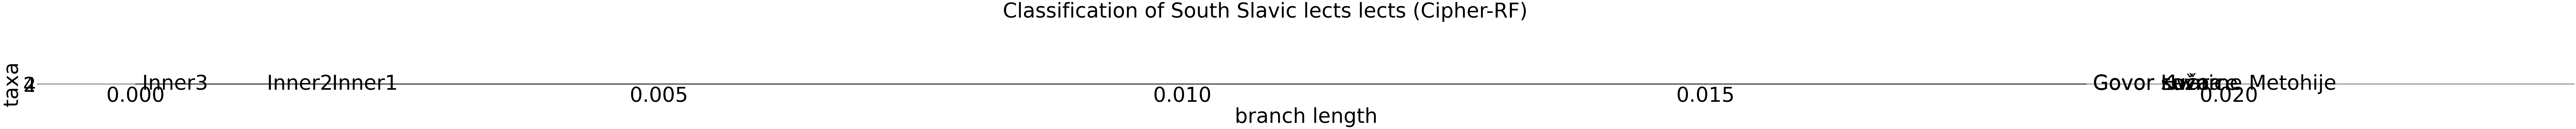

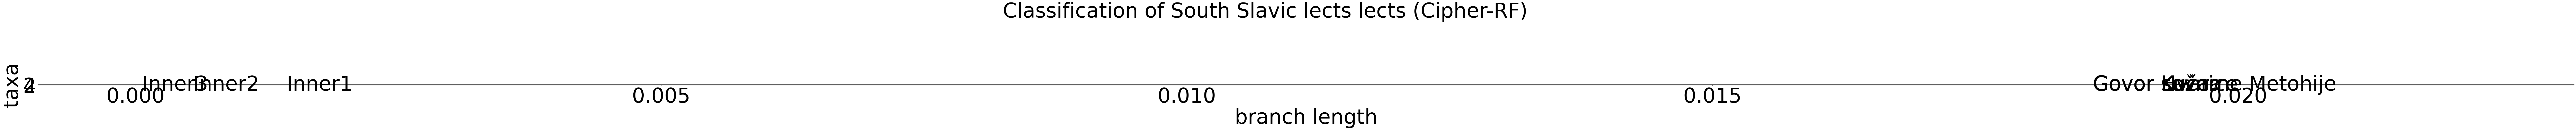

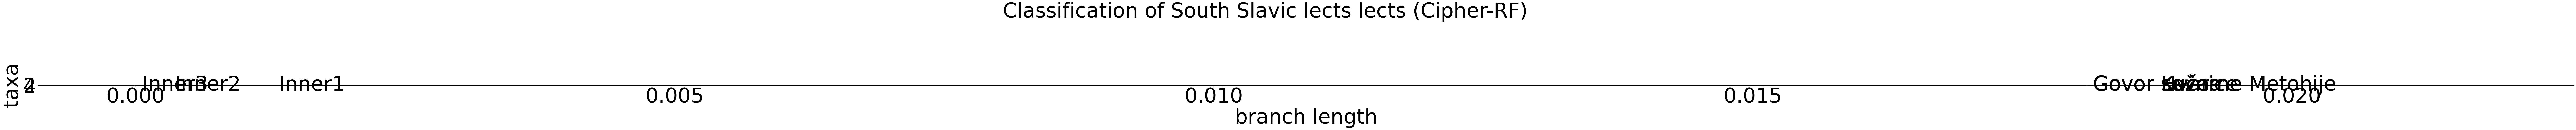

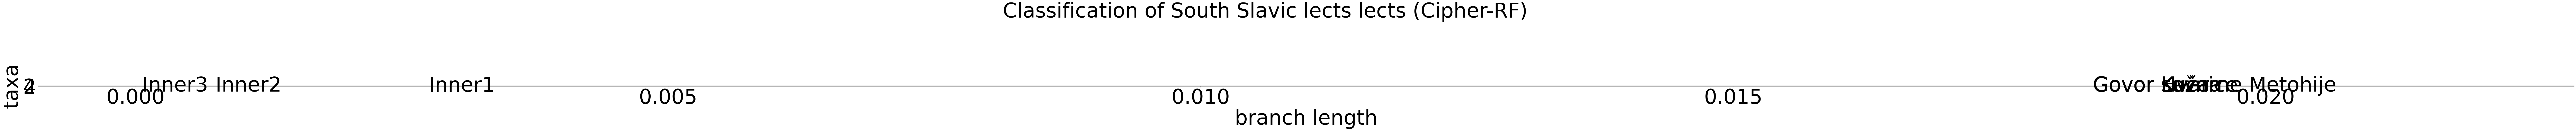

KeyboardInterrupt: 

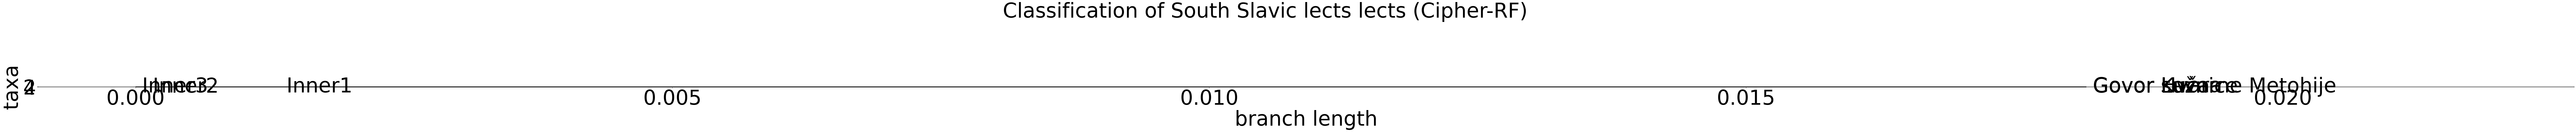

In [354]:
# for visual presentation, we prefer using upgma to nj,
# as nj tends to assign negative values to some branches,
# upgma provides more comprehensible binary split
# and differences in rate of evolution
# for these lects does not differ in a drastic manner
for r in range(NUM_RUNS):
  names = [str(i) for i in list(set(y))]
  lists_result = final_matrices[r]
  distance_matrix = _DistanceMatrix(names, lists_result)
  tree = constructor.upgma(distance_matrix)
  %matplotlib inline
  font = {'family':'DejaVu Sans', 'weight':'normal', 'size':72}
  matplotlib.rc('font', **font)
  fig = plt.figure(figsize=(160, 40))
  fig.suptitle(f'Classification of {DATA} lects (Cipher-RF)', fontsize=72)
  axes = fig.add_subplot(NUM_RUNS, 1, r + 1)
  Phylo.draw(tree, axes=axes, show_confidence=False, do_show=False)
  plt.savefig(f'phylogeny_black_box_{DATA}_run_{r}.png')
  plt.show()

## Threshold

String similarity measures are a simple method that is often used in computational phylogenetic linguistics. We use Levenshtein distance normalised divided (LDND) is the most traditional string similarity measure for computational phylogenetic linguistics. It scores additions, deletions and substitutions between two strings. We then normalise it by the length of the bigger word in pair. The metric present distance between lects as a mean of normalised Levenshtein distances.

For this experiment, we add different variations of handling situations, when at least in one lect there is more than one alternative for the concept.

The possible options are:

* OVERALL_MEAN: scoring mean among all the distances (a<sub>i</sub>, b<sub>j</sub>) for all realisations a<sub>1</sub>..a<sub>n</sub> and b<sub>1</sub>..b<sub>m</sub> of concept C in lects A and B respectively.
* MEAN_MEAN: scoring mean among means of the distances (a<sub>i</sub>, b<sub>j</sub>) for each realisation a<sub>1</sub>..a<sub>n</sub> and realisations b<sub>1</sub>..b<sub>m</sub> of concept C in lects A and B respectively.
* MEAN_MIN: scoring mean among minimal distances (a<sub>i</sub>, b<sub>j</sub>) for each realisation a<sub>1</sub>..a<sub>n</sub> and realisations b<sub>1</sub>..b<sub>m</sub> of concept C in lects A and B respectively.
* MEAN_MAX: scoring mean among maximal distances (a<sub>i</sub>, b<sub>j</sub>) for each realisation a<sub>1</sub>..a<sub>n</sub> and realisations b<sub>1</sub>..b<sub>m</sub> of concept C in lects A and B respectively.
* MIN_MEAN: picking minimal value among means of the distances (a<sub>i</sub>, b<sub>j</sub>) for each realisation a<sub>1</sub>..a<sub>n</sub> and realisations b<sub>1</sub>..b<sub>m</sub> of concept C in lects A and B respectively.
* MAX_MEAN: picking maximal value among means of the distances (a<sub>i</sub>, b<sub>j</sub>) for each realisation a<sub>1</sub>..a<sub>n</sub> and realisations b<sub>1</sub>..b<sub>m</sub> of concept C in lects A and B respectively.  

In [40]:
METHODS = {
    'OVERALL_MEAN': 'scoring mean among all the distances (ai, bj) for all realisations a1..an and b1..bm of concept C in lects A and B respectively.',
    'MEAN_MEAN': 'scoring mean among means of the distances (ai, bj) for each realisation a1..an and realisations b1..bm of concept C in lects A and B respectively.',
    'MEAN_MIN': 'scoring mean among minimal distances (ai, bj) for each realisation a1..an and realisations b1..bm of concept C in lects A and B respectively.',
    'MEAN_MAX': 'scoring mean among maximal distances (ai, bj) for each realisation a1..an and realisations b1..bm of concept C in lects A and B respectively.',
    'MIN_MEAN': 'picking minimal value among means of the distances (ai, bj) for each realisation a1..an and realisations b1..bm of concept C in lects A and B respectively.',
    'MAX_MEAN': 'picking maximal value among means of the distances (ai, bj) for each realisation a1..an and realisations b1..bm of concept C in lects A and B respectively.',
}

In [138]:
# we state the option that we want to use
METHOD = 'MAX_MEAN'

In [139]:
def aggregate_levenshtein(words_l1, words_l2, method, delimiter='_'):
  if method == 'OVERALL_MEAN':
    diffs = []
    for i in words_l1.split(delimiter):
      for j in words_l2.split(delimiter):
        diffs.append(Levenshtein.distance(i, j)/max([len(i), len(j)]))
    return sum(diffs)/len(diffs)
  elif method == 'MEAN_MEAN':
    diffs = []
    for i in words_l1.split(delimiter):
      i_levs = []
      for j in words_l2.split(delimiter):
        i_levs.append(Levenshtein.distance(i, j)/max([len(i), len(j)]))
      diffs.append(sum(i_levs)/len(i_levs))
    return sum(diffs)/len(diffs)
  elif method == 'MEAN_MIN':
    diffs = []
    for i in words_l1.split(delimiter):
      i_levs = []
      for j in words_l2.split(delimiter):
        i_levs.append(Levenshtein.distance(i, j)/max([len(i), len(j)]))
      diffs.append(min(i_levs))
    return sum(diffs)/len(diffs)
  elif method == 'MEAN_MAX':
    diffs = []
    for i in words_l1.split(delimiter):
      i_levs = []
      for j in words_l2.split(delimiter):
        i_levs.append(Levenshtein.distance(i, j)/max([len(i), len(j)]))
      diffs.append(max(i_levs))
    return sum(diffs)/len(diffs)
  elif method == 'MIN_MEAN':
    diffs = []
    for i in words_l1.split(delimiter):
      i_levs = []
      for j in words_l2.split(delimiter):
        i_levs.append(Levenshtein.distance(i, j)/max([len(i), len(j)]))
      diffs.append(sum(i_levs)/len(i_levs))
    return min(diffs)
  elif method == 'MAX_MEAN':
    diffs = []
    for i in words_l1.split(delimiter):
      i_levs = []
      for j in words_l2.split(delimiter):
        i_levs.append(Levenshtein.distance(i, j)/max([len(i), len(j)]))
      diffs.append(sum(i_levs)/len(i_levs))
    return max(diffs)
  else:
    raise ValueError('Incorrect method')



In [140]:
pairwise_distances = []
for i in tqdm(unique_pairs):
  neutral_lects = get_non_relevant_pairs(i, df_pairs)
  # get data for pair under consideration
  lect_1 = df[df['lect'] == i[0]]
  lect_2 = df[df['lect'] == i[1]]
  # get all the concept
  concepts = list(lect_1['concept'].unique())
  concept_distances = []
  # for each concept, we calculate aggregated normalised Levenshtein distance
  for c in concepts:
    concept_in_lect_1 = lect_1[lect_1['concept'] == c].reset_index().loc[0, 'word']
    concept_in_lect_2 = lect_2[lect_2['concept'] == c].reset_index().loc[0, 'word']
    concept_distances.append(aggregate_levenshtein(concept_in_lect_1, concept_in_lect_2, METHOD))
  # get mean for all the concepts in pair
  pairwise_distances.append((i, sum(concept_distances)/len(concept_distances)))
print(pairwise_distances)

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 46.89it/s]

[(('Govor Kuča', 'Govor Hvara'), 0.3428705979692822), (('Govor Kuča', 'Govor severne Metohije'), 0.203149701176017), (('Govor Kuča', 'Govor Lužnice'), 0.2854427736006684), (('Govor Hvara', 'Govor severne Metohije'), 0.32816416040100244), (('Govor Hvara', 'Govor Lužnice'), 0.3416196741854637), (('Govor severne Metohije', 'Govor Lužnice'), 0.24035087719298248)]


In [141]:
final_matrix = []
lects = list(set(y))
row = 0
for i in range(len(lects)):
    final_matrix.append([])
    for j in range(len(lects)):
        if j < i:
            dist = [d[1] for d in pairwise_distances if set([lects[i], lects[j]]) == set([d[0][0], d[0][1]])][0] 
            final_matrix[i].append(dist)    
    final_matrix[i].append(0)
print(final_matrix)

[[0], [0.3428705979692822, 0], [0.203149701176017, 0.32816416040100244, 0], [0.2854427736006684, 0.3416196741854637, 0.24035087719298248, 0]]


In [142]:
# prepare triangular matrix: names of lects and distances between them
# save the tree in newick format for further analysis
names = [str(i) for i in list(set(y))]
lists_result = final_matrix
distance_matrix = _DistanceMatrix(names, lists_result)
constructor = DistanceTreeConstructor()
tree = constructor.nj(distance_matrix)
print(tree)
Phylo.write(tree, f'tree_LDND_{DATA}_{METHOD}.newick', 'newick')

Tree(rooted=False)
    Clade(branch_length=0, name='Inner2')
        Clade(branch_length=0.026822414610243595, name='Inner1')
            Clade(branch_length=0.08662526709401713, name='Govor severne Metohije')
            Clade(branch_length=0.11652443408199986, name='Govor Kuča')
        Clade(branch_length=0.20712011398689026, name='Govor Hvara')
        Clade(branch_length=0.1344995601985734, name='Govor Lužnice')


1

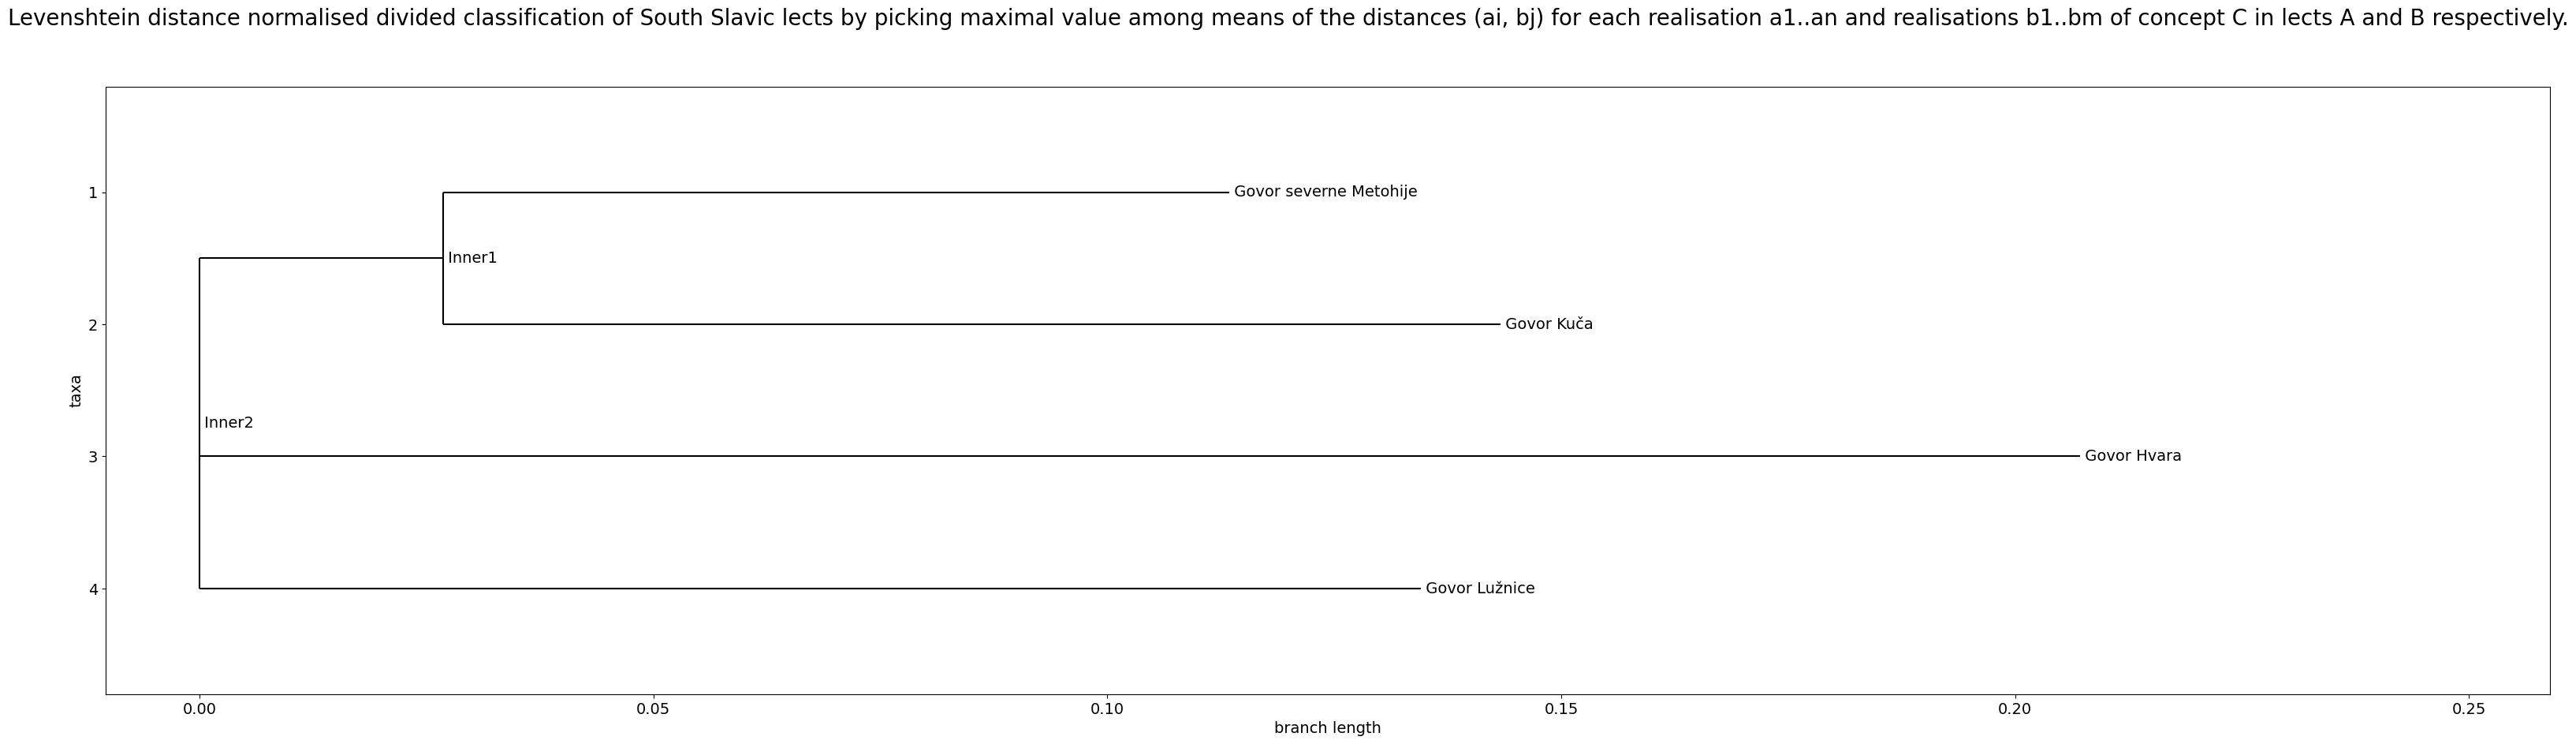

In [143]:
# for visual presentation, we prefer using upgma to nj,
# as nj tends to assign negative values to some branches,
# upgma provides more comprehensible binary split
# and differences in rate of evolution
# for these lects does not differ in a drastic manner
tree = constructor.nj(distance_matrix)
%matplotlib inline
font = {'family':'DejaVu Sans', 'weight':'normal', 'size':14}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(40, 10))
fig.suptitle(f'Levenshtein distance normalised divided classification of {DATA} by {METHODS[METHOD]}', fontsize=20)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes, show_confidence=False, do_show=False)
plt.savefig(f'phylogeny_LDND_{DATA}_{METHOD}.png')
plt.show()

# Adding threshold

Additional alternative is to use threshold for automatic elimination of the obvious non-cognates. With this method, we take only those distances that are less than this threshold. By default we utilise a free threshold of 0.66 (circa one third part between two words must align); we also take the minimal possible distance.

In [111]:
METHOD = 'THRESHOLD'
OMEGA = 0.9

In [112]:
def aggregate_levenshtein_with_threshold(l1, l2, words_l1, words_l2, df_with_metrics, threshold = 0.66, delimiter='_'):
  diffs = []
  levs = []
  for i in words_l1.split(delimiter):
    for j in words_l2.split(delimiter):
      LDN = Levenshtein.distance(i, j)/max([len(i), len(j)])
      if (LDN < threshold):
        diffs.append(LDN)
      levs.append([l1, l2, i, j, threshold, LDN])
  return (levs, min(diffs) if len(diffs) > 0 else 0)

In [113]:
pairwise_distances = []
pairwise_levs = []
for i in tqdm(unique_pairs):
  neutral_lects = get_non_relevant_pairs(i, df_pairs)
  # get data for pair under consideration
  lect_1 = df[df['lect'] == i[0]]
  lect_2 = df[df['lect'] == i[1]]
  # get all the concept
  concepts = list(lect_1['concept'].unique())
  concept_distances = []
  # for each concept, we calculate normalised Levenshtein distance
  for c in concepts:
    concept_in_lect_1 = lect_1[lect_1['concept'] == c].reset_index().loc[0, 'word']
    concept_in_lect_2 = lect_2[lect_2['concept'] == c].reset_index().loc[0, 'word']
    levs, aggregated_distance = aggregate_levenshtein_with_threshold(i[0], i[1], concept_in_lect_1, concept_in_lect_2, pairwise_levs, OMEGA)
    pairwise_levs.extend(levs)
    concept_distances.append(aggregated_distance)
  # get mean for all the concepts in pair
  pairwise_distances.append((i, sum(concept_distances)/len(concept_distances)))
print(pairwise_distances)

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 45.51it/s]

[(('Govor Kuča', 'Govor Hvara'), 0.16312656641604012), (('Govor Kuča', 'Govor severne Metohije'), 0.05159774436090226), (('Govor Kuča', 'Govor Lužnice'), 0.1204790823211876), (('Govor Hvara', 'Govor severne Metohije'), 0.14645989974937346), (('Govor Hvara', 'Govor Lužnice'), 0.19370300751879702), (('Govor severne Metohije', 'Govor Lužnice'), 0.11184210526315792)]


In [114]:
print(pairwise_levs)

[['Govor Kuča', 'Govor Hvara', 'krv', 'kor', 0.9, 0.6666666666666666], ['Govor Kuča', 'Govor Hvara', 'krv', 'korv', 0.9, 0.25], ['Govor Kuča', 'Govor Hvara', 'kos', 'kost', 0.9, 0.25], ['Govor Kuča', 'Govor Hvara', 'grudi', 'nidra', 0.9, 1.0], ['Govor Kuča', 'Govor Hvara', 'grudi', 'parsi', 0.9, 0.8], ['Govor Kuča', 'Govor Hvara', 'grudi', 'sisa', 0.9, 1.0], ['Govor Kuča', 'Govor Hvara', 'ɲedra', 'nidra', 0.9, 0.4], ['Govor Kuča', 'Govor Hvara', 'ɲedra', 'parsi', 0.9, 1.0], ['Govor Kuča', 'Govor Hvara', 'ɲedra', 'sisa', 0.9, 0.8], ['Govor Kuča', 'Govor Hvara', 'prsi', 'nidra', 0.9, 1.0], ['Govor Kuča', 'Govor Hvara', 'prsi', 'parsi', 0.9, 0.2], ['Govor Kuča', 'Govor Hvara', 'prsi', 'sisa', 0.9, 0.75], ['Govor Kuča', 'Govor Hvara', 'sisa', 'nidra', 0.9, 0.6], ['Govor Kuča', 'Govor Hvara', 'sisa', 'parsi', 0.9, 0.8], ['Govor Kuča', 'Govor Hvara', 'sisa', 'sisa', 0.9, 0.0], ['Govor Kuča', 'Govor Hvara', 'doj', 'arivat', 0.9, 1.0], ['Govor Kuča', 'Govor Hvara', 'doj', 'arivovat', 0.9, 0.87

In [115]:
df_levs = pd.DataFrame(pairwise_levs, columns=['l1', 'l2', 'word1', 'word2', 'delimiter', 'metrics'])

In [116]:
df_levs.to_csv(f'Levenshtein_with_threshold_{OMEGA}.csv', index=False)

In [117]:
final_matrix = []
lects = list(set(y))
row = 0
for i in range(len(lects)):
    final_matrix.append([])
    for j in range(len(lects)):
        if j < i:
            dist = [d[1] for d in pairwise_distances if set([lects[i], lects[j]]) == set([d[0][0], d[0][1]])][0] 
            final_matrix[i].append(dist)    
    final_matrix[i].append(0)
print(final_matrix)

[[0], [0.16312656641604012, 0], [0.05159774436090226, 0.14645989974937346, 0], [0.1204790823211876, 0.19370300751879702, 0.11184210526315792, 0]]


In [118]:
# prepare triangular matrix: names of lects and distances between them
names = [str(i) for i in list(set(y))]
lists_result = final_matrix
distance_matrix = _DistanceMatrix(names, lists_result)
constructor = DistanceTreeConstructor()
tree = constructor.nj(distance_matrix)
print(tree)
# we save tree for further use
Phylo.write(tree, f'tree_LDND_{DATA}_{METHOD}_{OMEGA}.newick', 'newick')

Tree(rooted=False)
    Clade(branch_length=0, name='Inner2')
        Clade(branch_length=0.07753518411413149, name='Govor Lužnice')
        Clade(branch_length=0.012826537497590149, name='Inner1')
            Clade(branch_length=0.01947296124927704, name='Govor severne Metohije')
            Clade(branch_length=0.03212478311162522, name='Govor Kuča')
        Clade(branch_length=0.11616782340466553, name='Govor Hvara')


1

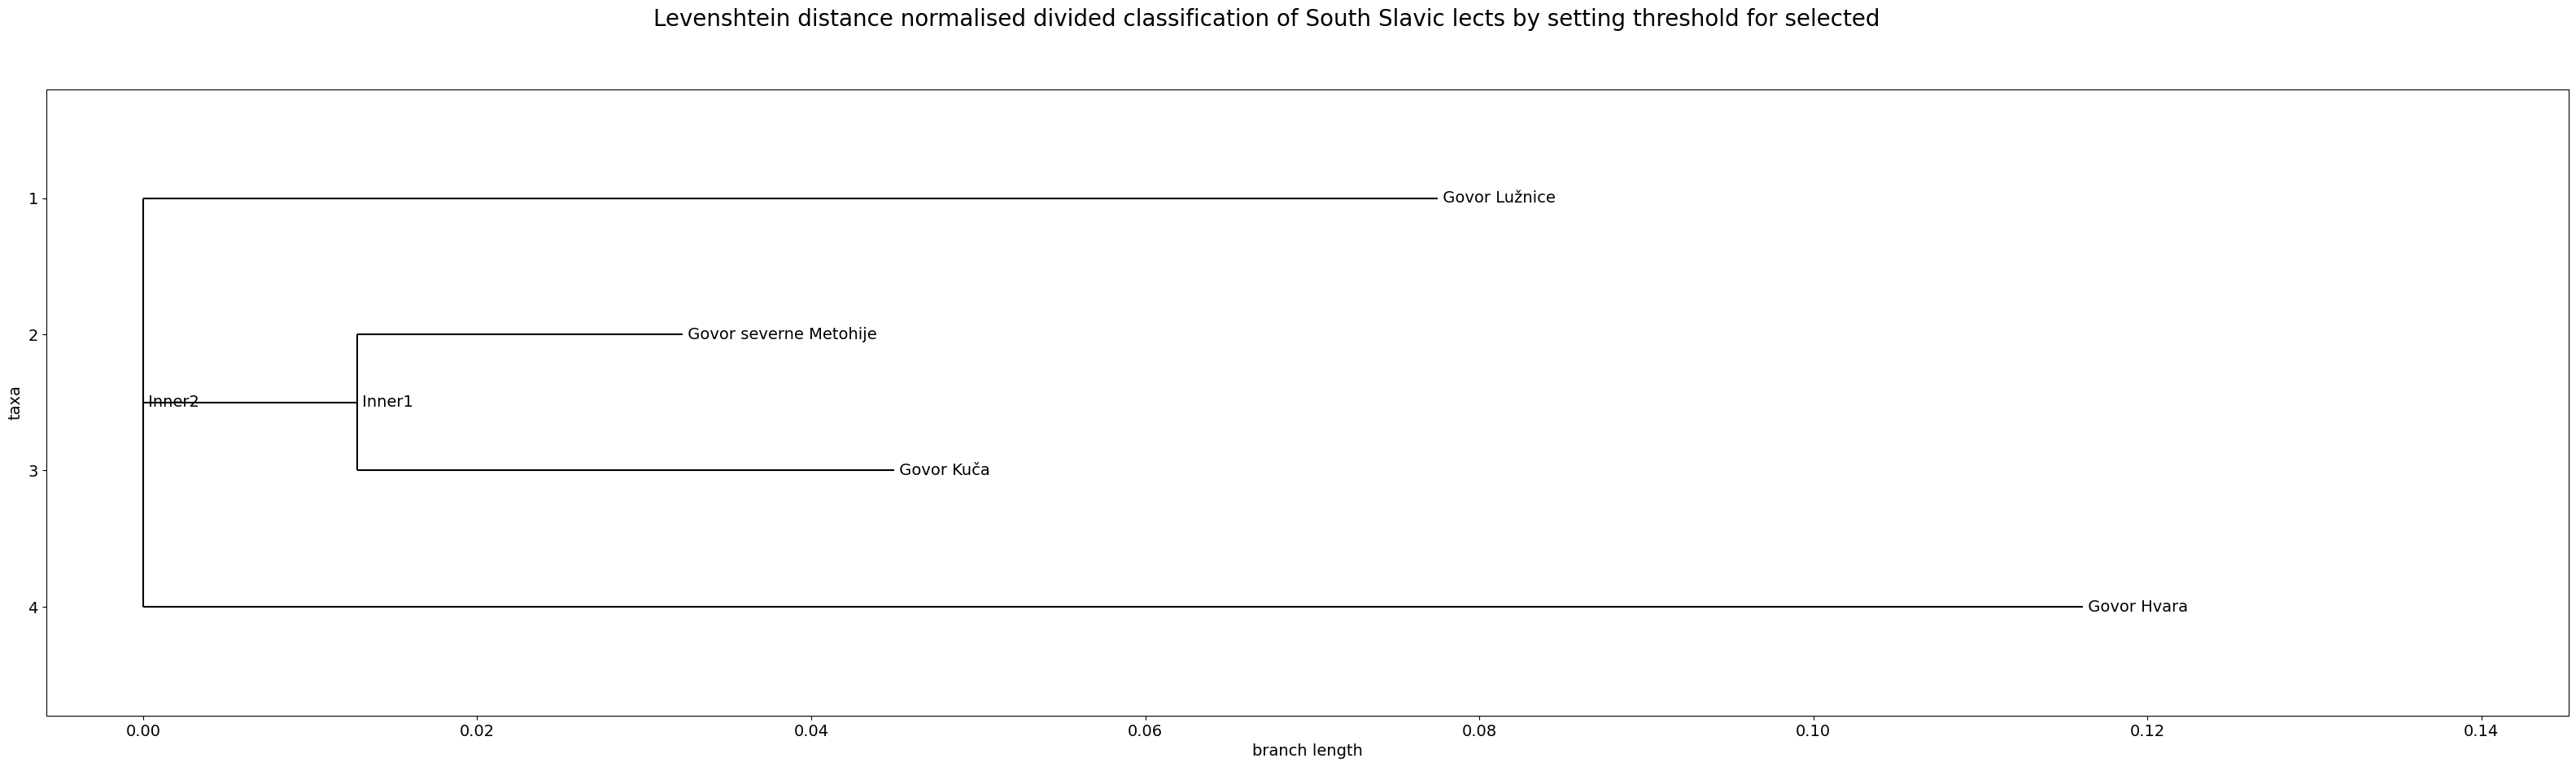

In [119]:
# for visual presentation, we prefer using upgma to nj,
# as nj tends to assign negative values to some branches,
# upgma provides more comprehensible binary split
# and differences in rate of evolution
# for these lects does not differ in a drastic manner
tree = constructor.nj(distance_matrix)
%matplotlib inline
font = {'family':'DejaVu Sans', 'weight':'normal', 'size':14}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(40, 10))
fig.suptitle(f'Levenshtein distance normalised divided classification of {DATA} by setting threshold for selected', fontsize=20)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes, show_confidence=False, do_show=False)
plt.savefig(f'phylogeny_LDND_{DATA}.png')
plt.show()